In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/gauri-foundry/Desktop/eval_SME/sme-invoicing-assistant


In [51]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/gauri-foundry/Desktop/eval_SME/sme-invoicing-assistant/.env.example


True

In [52]:
import pandas as pd
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("results/llama3.2-vision_11b-qwen2.5_32b/emails.db")
# conn = sqlite3.connect("src/data/db/llama3.2-vision_11b-qwen2.5_32b/emails.db")

# Write your SQL query
query = "SELECT * FROM emails"

# Read the query results into a pandas DataFrame
df = pd.read_sql(query, conn)

df.head(5)

,email_id,sender_email,recipient_email,subject,email_body,attachments,process_status,response,start_time,end_time,total_time,successful_requests,total_tokens,prompt_tokens,completion_tokens,total_cost
0,93185A89130149C0A842968E4AFDCAA2,RobinLevine@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 43925,Hi Tanya ! Please find attached payment screen...,transaction_1.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-19T12:38:44.897633,2025-01-19T12:39:22.174910,0.2773,8,2828,2302,526,0.0
1,614972488B7B411BAEA4814CF066CDAA,StevenNixon@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 51782,Hi Tanya ! Please find attached payment screen...,transaction_2.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-19T12:39:22.186091,2025-01-19T12:39:33.450020,0.2639,28,10314,8452,1862,0.0
2,C484ABEB38F44D29960B1CEF58510627,MadisonFord@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 42968,Hi Tanya ! Please find attached payment screen...,transaction_3.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-19T12:39:33.458549,2025-01-19T12:39:44.217607,0.7591,60,22347,18459,3888,0.0
3,706B3403E8024178948B3BFBF9E64A25,KathrynJones@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 92948,Hi Tanya ! Please find attached payment screen...,transaction_4.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-19T12:39:44.225788,2025-01-19T12:39:57.151574,0.9258,104,39028,32374,6654,0.0
4,86838440CA6C472AACFA3FCE1382609C,ChristineOwens@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 20304,Hi Tanya ! Please find attached payment screen...,transaction_5.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-19T12:39:57.159558,2025-01-19T12:40:08.401280,0.2417,160,60377,50201,10176,0.0


In [53]:
# Code to filter and remove repeated Invoice ID specific data from emails db
error_df = df.loc[df["process_status"] == "ERROR", ["response", "email_id"]]
ground_truth_df = pd.read_csv("./src/data/synthetic_data/ground_truth_data.csv")
ground_truth_df.head()
matching_rows = ground_truth_df[ground_truth_df["email_id"].isin(error_df["email_id"])]
# print(matching_rows)
error_df = error_df.merge(
    matching_rows[["email_id", "invoice_id", "amount"]], on="email_id", how="left"
)
transactions_df = pd.read_csv("./src/data/synthetic_data/transactions.csv")
ground_truth_df = pd.read_csv("./ground_truth_data 2.csv")
duplicate_rows = transactions_df[transactions_df["invoice_id"].duplicated(keep=False)]
# print(duplicate_rows)
num_duplicates = transactions_df["invoice_id"].duplicated().sum()
# print(f"Number of duplicate invoice_ids: {num_duplicates}")
duplicated_invoice_ids = transactions_df[
    transactions_df["invoice_id"].duplicated(keep=False)
]["invoice_id"].unique()
print("Unique duplicated invoice_ids:")
print(duplicated_invoice_ids)
matched_rows_emailid = ground_truth_df[
    ground_truth_df["invoice_id"].isin(duplicated_invoice_ids)
]
email_id_associated_with_duplicated_invoice_id = matched_rows_emailid[
    "email_id"
].tolist()
# print(email_id_associated_with_duplicated_invoice_id)
# print(len(email_id_associated_with_duplicated_invoice_id))

Unique duplicated invoice_ids:
['47535' '83211' '33011' '32831' '78443' 'I20283' 'I17919' 'I19555'
 'I13830' 'I15694' 'I11539' 'I12224' 'I11959' 'I15130' 'I13807' 'I16375'
 'I15190' 'I16935' 'I18364' 'I18536' 'I11126' 'I15903' 'I15165' 'I12970'
 'I15573' 'I14987' 'I13368' 'I20256' 'I17489' 'I12089' 'I19233' 'I14854'
 'I17006' 'I17250' 'I13980' 'I12734' 'I20809' 'I20544' 'I10079' 'I17774'
 'I18754' 'I16990' 'I19919' 'I15684' 'I19904' 'I14215' 'I11364' 'I13212'
 'I13346' 'I15199' 'I16771' 'I16433']


In [54]:
## DF without repeated Invoice ID's

df_filtered = df[~df["email_id"].isin(email_id_associated_with_duplicated_invoice_id)]

In [55]:
print(df_filtered.describe())

                                email_id              sender_email  \
count                               1895                      1895   
unique                              1895                      1883   
top     93185A89130149C0A842968E4AFDCAA2  MichaelJones@example.com   
freq                                   1                         3   

                     recipient_email  \
count                           1895   
unique                             1   
top     tanya.official.456@gmail.com   
freq                            1895   

                                           subject  \
count                                         1895   
unique                                        1895   
top     Payment Confirmation for Invoice ID: 43925   
freq                                             1   

                                               email_body attachments  \
count                                                1895        1895   
unique                         

In [56]:
import matplotlib.pyplot as plt


def plot_value_distribution(df_filtered, col="category", top_n=10):
    df_filtered[col].value_counts()[:top_n].plot(kind="bar")
    plt.title(f"Distribution of {col}")

    # add the count on top of the bars
    for i in range(len(df_filtered[col].value_counts()[:top_n])):
        count = df_filtered[col].value_counts().values[i]
        plt.text(i, count, count, ha="center")

    plt.show()

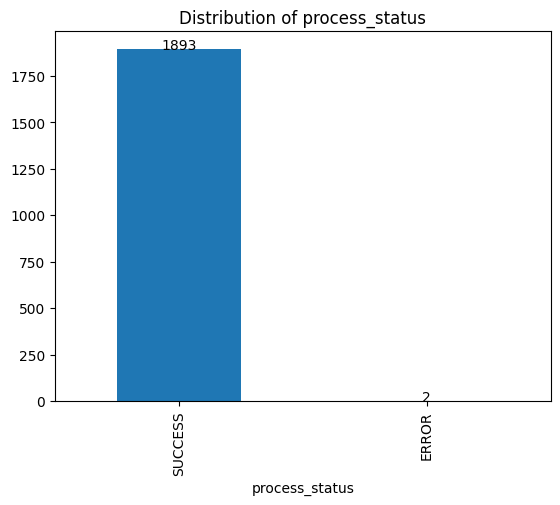

In [57]:
plot_value_distribution(df_filtered, "process_status")

In [58]:
error_df = df_filtered[df_filtered["process_status"] == "ERROR"]

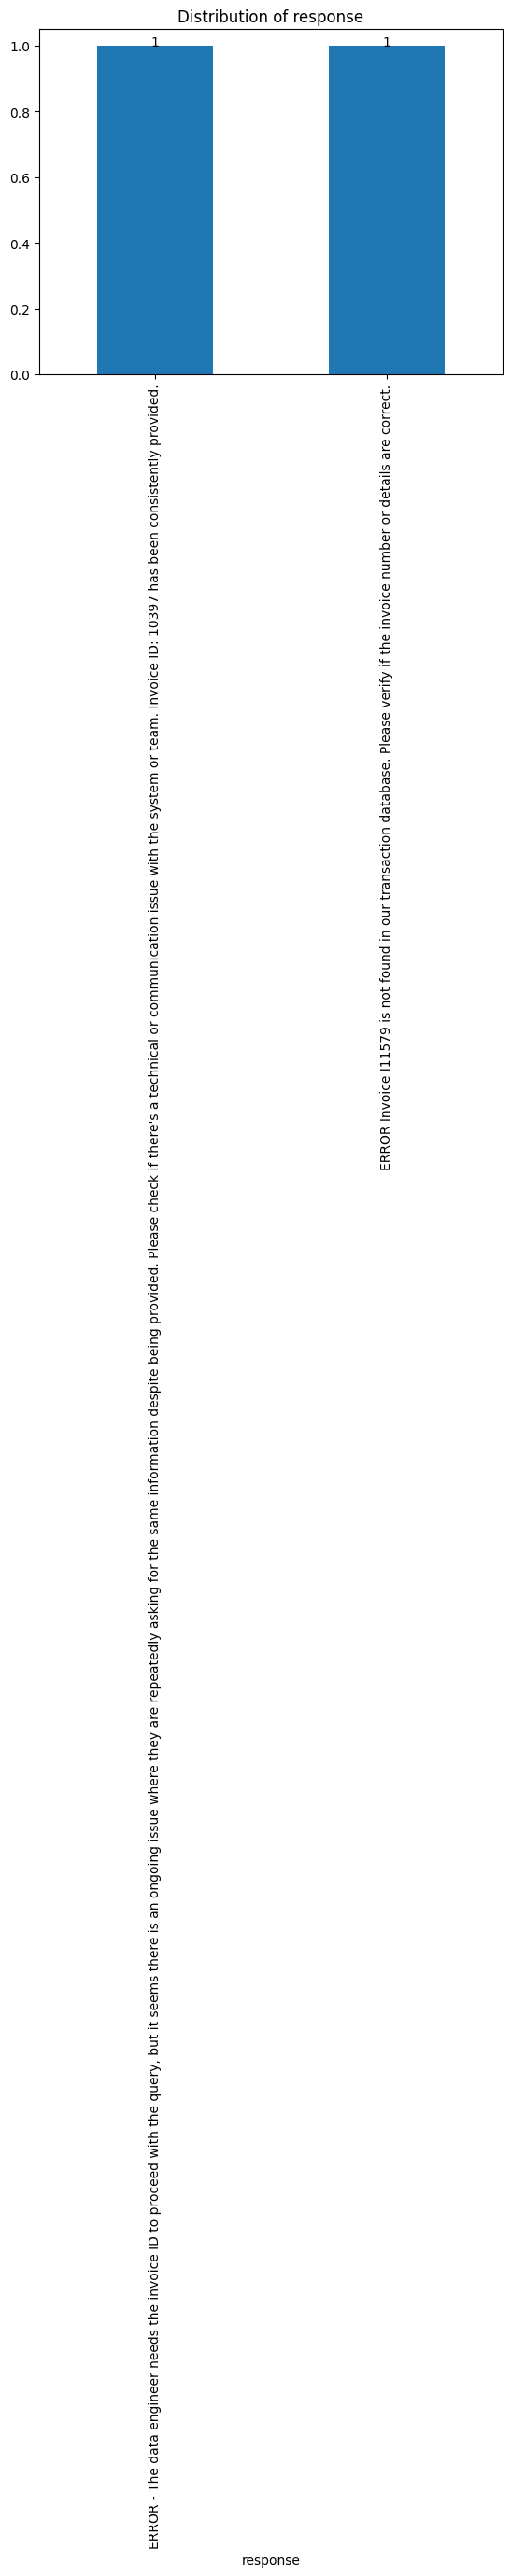

In [59]:
plot_value_distribution(error_df, "response")

In [60]:
error_df.to_csv(
    "results/llama3.2-vision_11b-qwen2.5_32b/error_analysis_llama3.2-vision_11b-qwen2.5_32b.csv"
)

In [61]:
df_filtered["end_time"] = pd.to_datetime(df["end_time"])
df_filtered["start_time"] = pd.to_datetime(df["start_time"])
df_filtered["duration"] = (
    df_filtered["end_time"] - df_filtered["start_time"]
).dt.total_seconds()
df_filtered[["duration", "total_time"]].head()

/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_4782/781749110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["end_time"] = pd.to_datetime(df["end_time"])
/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_4782/781749110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["start_time"] = pd.to_datetime(df["start_time"])
/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_4782/781749110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

,duration,total_time
0,37.277277,0.2773
1,11.263929,0.2639
2,10.759058,0.7591
3,12.925786,0.9258
4,11.241722,0.2417


<Axes: ylabel='Frequency'>

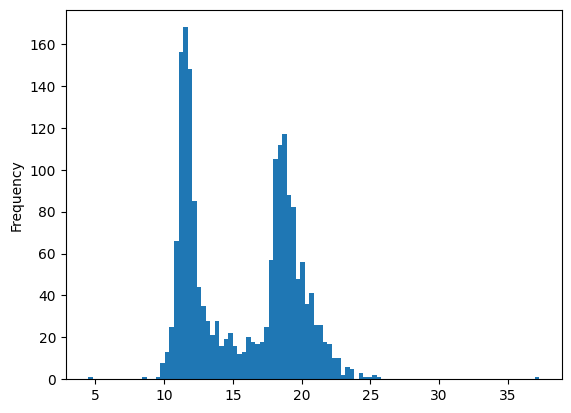

In [62]:
# plot the distribution of duration
df_filtered["duration"].plot(kind="hist", bins=100)

In [63]:
df_filtered["duration"].describe()

count    1895.000000
mean       15.725714
std         3.845791
min         4.488136
25%        11.759685
50%        16.303504
75%        18.949427
max        37.277277
Name: duration, dtype: float64

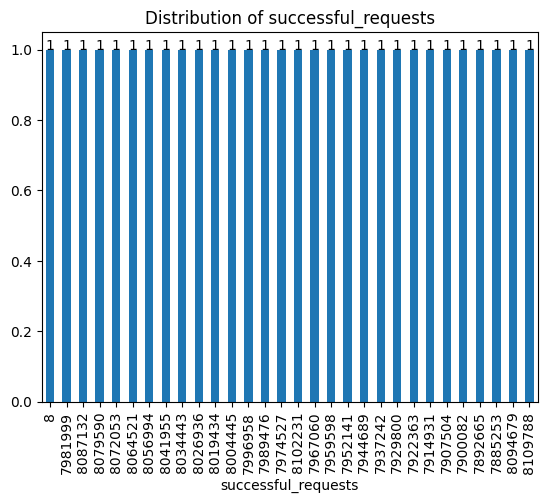

In [64]:
plot_value_distribution(df_filtered, "successful_requests", top_n=30)

In [65]:
df_filtered["process_status"].value_counts()

process_status
SUCCESS    1893
ERROR         2
Name: count, dtype: int64

** Success Rate **

In [66]:
success_rate = df_filtered["process_status"].value_counts()["SUCCESS"] / len(
    df_filtered
)
success_rate

0.9989445910290238

** Idle Power **

In [67]:
def total_power_in_watt(file_path):
    df = pd.read_csv(file_path)
    return df["CPU Package Power [W]"].mean() + df["GPU Power [W]"].mean()


power_idle = total_power_in_watt("results/power_idle.csv")
power_idle

29.873

** Power with and Without Vision **

In [68]:
power_with_vision = total_power_in_watt(
    "results/llama3.2-vision_11b-qwen2.5_32b/power_with_vision.csv"
)
power_without_vision = total_power_in_watt(
    "results/llama3.2-vision_11b-qwen2.5_32b/power_without_vision.csv"
)
power_with_vision, power_without_vision

(329.757, 327.73380000000003)

** Mean Response Time **

In [69]:
mean_response_time = df_filtered["duration"].mean()
mean_response_time

15.725714059630606

** Average Energy Consumption **

In [70]:
average_energy_consumption = (
    (power_with_vision + power_without_vision) / 2 - power_idle
) * mean_response_time
average_energy_consumption

4699.981902715543

In [71]:
row = df[df["process_status"] == "ERROR"].iloc[0]
row

email_id                                F2237157AD2542EB91ED5B4508C0B326
sender_email                                     JerryHuerta@example.com
recipient_email                             tanya.official.456@gmail.com
subject                       Payment Confirmation for Invoice ID: 47535
email_body             Hi Tanya ! Please find attached payment screen...
attachments                                         transaction_126.jpeg
process_status                                                     ERROR
response               ERROR - The invoice amount does not match. Acc...
start_time                                    2025-01-19T13:07:00.631371
end_time                                      2025-01-19T13:07:09.543617
total_time                                                        0.9122
successful_requests                                                95507
total_tokens                                                    38507238
prompt_tokens                                      

** Obeservations ***

1. 1 Error entry due to DB lockup issue
3. 1 Error Entry due to LLM hallucination /Agent not able to complete its task



